In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('result_file_total.csv')
df.shape

(160000, 7)

In [4]:
df.drop('id', axis=1, inplace=True)

In [5]:
df.head()

,PERM,L,H,C5,Years,Gas
0,0.2,100,1,0,1,46444
1,0.2,100,1,30,1,46414
2,0.2,100,1,45,1,46400
3,0.2,100,1,60,1,46385
4,0.2,100,1,75,1,46370


Cross-validated metrics for Years with Linear Regression:
R2: 0.562519602765737
RMSE: 2.5818251178464893
MAE: 2.1781867993382233
MAPE: 85.71552305972082
Cross-validated metrics for Years with CatBoost:
R2: 0.874819646277906
RMSE: 1.3810106922135164
MAE: 0.5784664711053737
MAPE: 25.77009090368211
Cross-validated metrics for Gas with Linear Regression:
R2: 0.8030372914794807
RMSE: 8517113.005055362
MAE: 5968803.224904594
MAPE: 1192.3692207969261
Cross-validated metrics for Gas with CatBoost:
R2: 0.8951039062427301
RMSE: 6215627.143355835
MAE: 3210151.7881389474
MAPE: 178.3201940864888
Test set metrics for Years with Linear Regression: {'R2': -62181534072543.555, 'RMSE': 2.5884431131250394, 'MAE': 2.1814396746347664, 'MAPE': 85.69033881952573}
Test set metrics for Years with CatBoost: {'R2': -64343767548213.06, 'RMSE': 1.3784941208270065, 'MAE': 0.5754392986145161, 'MAPE': 25.527401388877237}
Test set metrics for Gas with Linear Regression: {'R2': 0.7979911943071774, 'RMSE': 8598144.12412

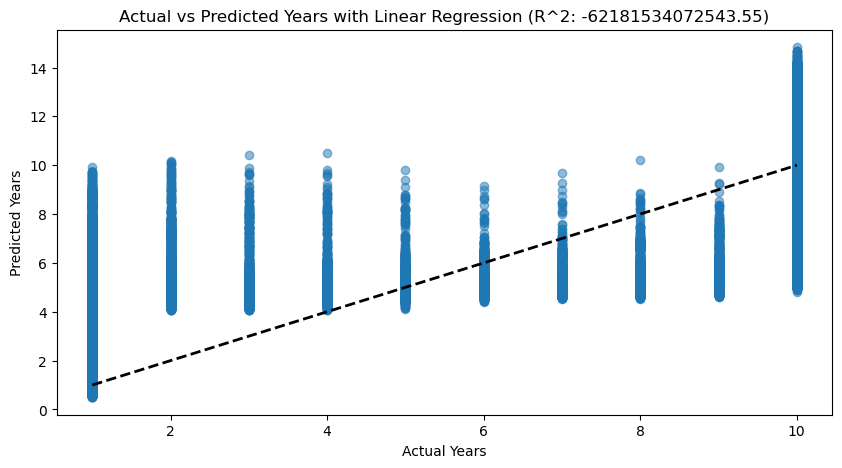

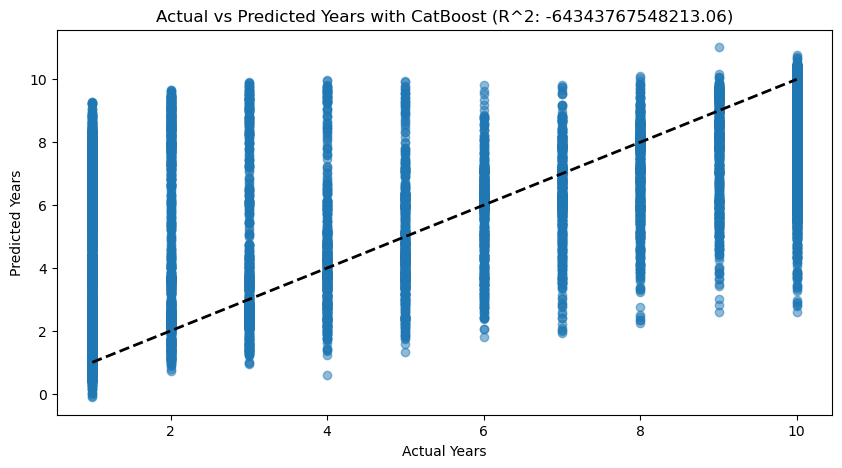

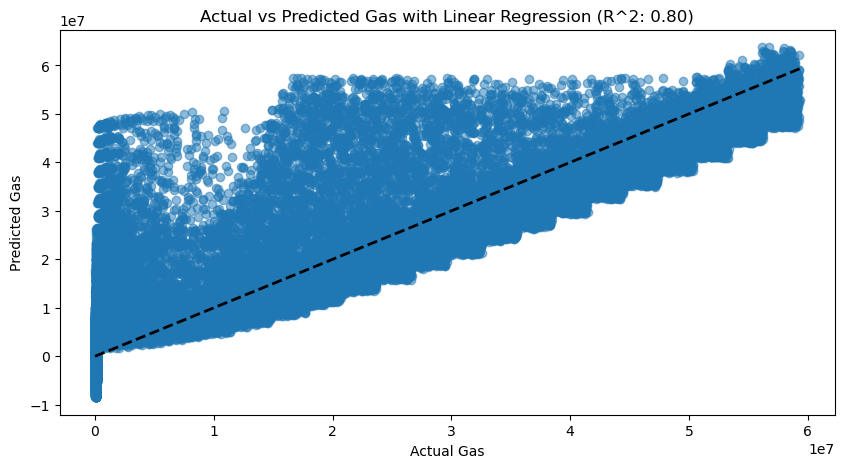

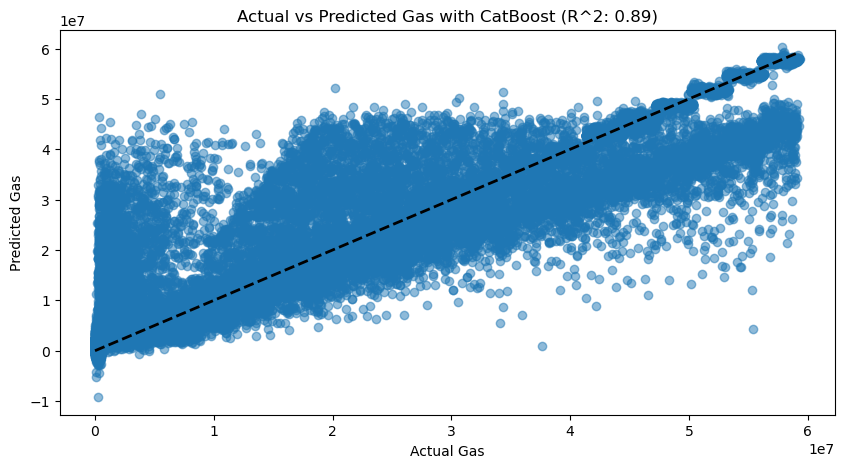

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

# Load the dataset
file_path = 'result_file_total.csv'
df = pd.read_csv(file_path)

# Drop the ID column
df.drop('id', axis=1, inplace=True)

# Separate features and target variables
X = df.drop(columns=['Years', 'Gas'])
y_years = df['Years']
y_gas = df['Gas']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define pipelines for Linear Regression and CatBoost
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

pipeline_cb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', CatBoostRegressor(silent=True))])

# Split the data into training and test sets (2/3 train, 1/3 test)
X_train, X_test, y_years_train, y_years_test, y_gas_train, y_gas_test = train_test_split(
    X, y_years, y_gas, test_size=1/3, random_state=42)

# Define custom scoring metrics
scoring = {
    'R2': 'r2',
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'MAPE': make_scorer(lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
}

# Perform 5-fold cross-validation for 'Years' with Linear Regression
cv_results_years_lr = cross_validate(pipeline_lr, X_train, y_years_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Years with Linear Regression:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_years_lr["test_" + metric].mean()}')

# Perform 5-fold cross-validation for 'Years' with CatBoost
cv_results_years_cb = cross_validate(pipeline_cb, X_train, y_years_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Years with CatBoost:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_years_cb["test_" + metric].mean()}')

# Perform 5-fold cross-validation for 'Gas' with Linear Regression
cv_results_gas_lr = cross_validate(pipeline_lr, X_train, y_gas_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Gas with Linear Regression:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_gas_lr["test_" + metric].mean()}')

# Perform 5-fold cross-validation for 'Gas' with CatBoost
cv_results_gas_cb = cross_validate(pipeline_cb, X_train, y_gas_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Gas with CatBoost:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_gas_cb["test_" + metric].mean()}')

# Fit the models on the entire training set and evaluate on the test set
# Linear Regression
pipeline_lr.fit(X_train, y_years_train)
y_years_pred_lr = pipeline_lr.predict(X_test)

pipeline_lr.fit(X_train, y_gas_train)
y_gas_pred_lr = pipeline_lr.predict(X_test)

# CatBoost
pipeline_cb.fit(X_train, y_years_train)
y_years_pred_cb = pipeline_cb.predict(X_test)

pipeline_cb.fit(X_train, y_gas_train)
y_gas_pred_cb = pipeline_cb.predict(X_test)

# Evaluate metrics on the test set for 'Years' with Linear Regression
test_metrics_years_lr = {
    'R2': pipeline_lr.score(X_test, y_years_test),
    'RMSE': mean_squared_error(y_years_test, y_years_pred_lr, squared=False),
    'MAE': mean_absolute_error(y_years_test, y_years_pred_lr),
    'MAPE': np.mean(np.abs((y_years_test - y_years_pred_lr) / y_years_test)) * 100
}
print(f'Test set metrics for Years with Linear Regression: {test_metrics_years_lr}')

# Evaluate metrics on the test set for 'Years' with CatBoost
test_metrics_years_cb = {
    'R2': pipeline_cb.score(X_test, y_years_test),
    'RMSE': mean_squared_error(y_years_test, y_years_pred_cb, squared=False),
    'MAE': mean_absolute_error(y_years_test, y_years_pred_cb),
    'MAPE': np.mean(np.abs((y_years_test - y_years_pred_cb) / y_years_test)) * 100
}
print(f'Test set metrics for Years with CatBoost: {test_metrics_years_cb}')

# Evaluate metrics on the test set for 'Gas' with Linear Regression
test_metrics_gas_lr = {
    'R2': pipeline_lr.score(X_test, y_gas_test),
    'RMSE': mean_squared_error(y_gas_test, y_gas_pred_lr, squared=False),
    'MAE': mean_absolute_error(y_gas_test, y_gas_pred_lr),
    'MAPE': np.mean(np.abs((y_gas_test - y_gas_pred_lr) / y_gas_test)) * 100
}
print(f'Test set metrics for Gas with Linear Regression: {test_metrics_gas_lr}')

# Evaluate metrics on the test set for 'Gas' with CatBoost
test_metrics_gas_cb = {
    'R2': pipeline_cb.score(X_test, y_gas_test),
    'RMSE': mean_squared_error(y_gas_test, y_gas_pred_cb, squared=False),
    'MAE': mean_absolute_error(y_gas_test, y_gas_pred_cb),
    'MAPE': np.mean(np.abs((y_gas_test - y_gas_pred_cb) / y_gas_test)) * 100
}
print(f'Test set metrics for Gas with CatBoost: {test_metrics_gas_cb}')

# Plot scatter plot for 'Years' with Linear Regression
plt.figure(figsize=(10, 5))
plt.scatter(y_years_test, y_years_pred_lr, alpha=0.5)
plt.plot([y_years_test.min(), y_years_test.max()], [y_years_test.min(), y_years_test.max()], 'k--', lw=2)
plt.xlabel('Actual Years')
plt.ylabel('Predicted Years')
plt.title(f'Actual vs Predicted Years with Linear Regression (R^2: {test_metrics_years_lr["R2"]:.2f})')
plt.show()

# Plot scatter plot for 'Years' with CatBoost
plt.figure(figsize=(10, 5))
plt.scatter(y_years_test, y_years_pred_cb, alpha=0.5)
plt.plot([y_years_test.min(), y_years_test.max()], [y_years_test.min(), y_years_test.max()], 'k--', lw=2)
plt.xlabel('Actual Years')
plt.ylabel('Predicted Years')
plt.title(f'Actual vs Predicted Years with CatBoost (R^2: {test_metrics_years_cb["R2"]:.2f})')
plt.show()

# Plot scatter plot for 'Gas' with Linear Regression
plt.figure(figsize=(10, 5))
plt.scatter(y_gas_test, y_gas_pred_lr, alpha=0.5)
plt.plot([y_gas_test.min(), y_gas_test.max()], [y_gas_test.min(), y_gas_test.max()], 'k--', lw=2)
plt.xlabel('Actual Gas')
plt.ylabel('Predicted Gas')
plt.title(f'Actual vs Predicted Gas with Linear Regression (R^2: {test_metrics_gas_lr["R2"]:.2f})')
plt.show()

# Plot scatter plot for 'Gas' with CatBoost
plt.figure(figsize=(10, 5))
plt.scatter(y_gas_test, y_gas_pred_cb, alpha=0.5)
plt.plot([y_gas_test.min(), y_gas_test.max()], [y_gas_test.min(), y_gas_test.max()], 'k--', lw=2)
plt.xlabel('Actual Gas')
plt.ylabel('Predicted Gas')
plt.title(f'Actual vs Predicted Gas with CatBoost (R^2: {test_metrics_gas_cb["R2"]:.2f})')
plt.show()


<AxesSubplot:>

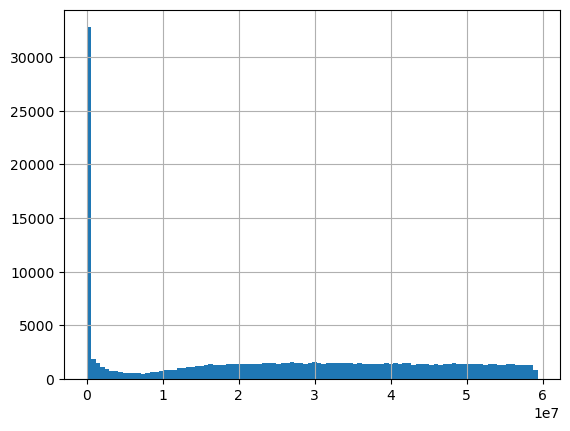

In [12]:
df['Gas'].hist(bins=100)

In [13]:
X.head()

,PERM,L,H,C5
0,1,1923,15,215
1,19,617,14,340
2,0,393,10,281
3,0,1222,8,117
4,52,2012,18,381


In [14]:
# New data sample
new_sample = pd.DataFrame({
    'PERM': [0.53],
    'L': [650],
    'H': [7.4],
    'C5': [70]
})

# Use the trained pipeline for Linear Regression to make predictions
# For 'Years'
y_years_pred_new_lr = pipeline_lr.predict(new_sample)
print(f'Linear Regression Prediction for Years: {y_years_pred_new_lr[0]}')

# For 'Gas'
y_gas_pred_new_lr = pipeline_lr.predict(new_sample)
print(f'Linear Regression Prediction for Gas: {y_gas_pred_new_lr[0]}')

# Use the trained pipeline for CatBoost to make predictions
# For 'Years'
y_years_pred_new_cb = pipeline_cb.predict(new_sample)
print(f'CatBoost Prediction for Years: {y_years_pred_new_cb[0]}')

# For 'Gas'
y_gas_pred_new_cb = pipeline_cb.predict(new_sample)
print(f'CatBoost Prediction for Gas: {y_gas_pred_new_cb[0]}')


Linear Regression Prediction for Years: 14178119.914793106
Linear Regression Prediction for Gas: 14178119.914793106
CatBoost Prediction for Years: 17106388.69075458
CatBoost Prediction for Gas: 17106388.69075458


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor

# Load the dataset
file_path = 'result_file_total.csv'
df = pd.read_csv(file_path)

# Drop the ID column
df.drop('id', axis=1, inplace=True)

# Separate features and target variables
X = df.drop(columns=['Years', 'Gas'])
y_years = df['Years']
y_gas = df['Gas']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply clustering to numeric features after preprocessing
class ClusterTransformer:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.kmeans = None
    
    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans.fit(X)
        return self
    
    def transform(self, X):
        X_clustered = self.kmeans.transform(X)
        return np.hstack([X, X_clustered])

# Add feature clustering step to the pipeline
clustering = Pipeline(steps=[('preprocessor', preprocessor),
                             ('cluster', ClusterTransformer(n_clusters=3))])

# Define pipelines for Linear Regression and CatBoost
pipeline_lr = Pipeline(steps=[('clustering', clustering),
                              ('regressor', LinearRegression())])

pipeline_cb = Pipeline(steps=[('clustering', clustering),
                              ('regressor', CatBoostRegressor(silent=True))])

# Split the data into training and test sets (2/3 train, 1/3 test)
X_train, X_test, y_years_train, y_years_test, y_gas_train, y_gas_test = train_test_split(
    X, y_years, y_gas, test_size=1/3, random_state=42)

# Define custom scoring metrics
scoring = {
    'R2': 'r2',
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'MAPE': make_scorer(lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
}

# Perform 5-fold cross-validation for 'Years' with Linear Regression
cv_results_years_lr = cross_validate(pipeline_lr, X_train, y_years_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Years with Linear Regression:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_years_lr["test_" + metric].mean()}')

# Perform 5-fold cross-validation for 'Years' with CatBoost
cv_results_years_cb = cross_validate(pipeline_cb, X_train, y_years_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Years with CatBoost:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_years_cb["test_" + metric].mean()}')

# Perform 5-fold cross-validation for 'Gas' with Linear Regression
cv_results_gas_lr = cross_validate(pipeline_lr, X_train, y_gas_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Gas with Linear Regression:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_gas_lr["test_" + metric].mean()}')

# Perform 5-fold cross-validation for 'Gas' with CatBoost
cv_results_gas_cb = cross_validate(pipeline_cb, X_train, y_gas_train, cv=5, scoring=scoring)
print(f'Cross-validated metrics for Gas with CatBoost:')
for metric in scoring.keys():
    print(f'{metric}: {cv_results_gas_cb["test_" + metric].mean()}')

# Fit the models on the entire training set and evaluate on the test set
# Linear Regression
pipeline_lr.fit(X_train, y_years_train)
y_years_pred_lr = pipeline_lr.predict(X_test)

pipeline_lr.fit(X_train, y_gas_train)
y_gas_pred_lr = pipeline_lr.predict(X_test)

# CatBoost
pipeline_cb.fit(X_train, y_years_train)
y_years_pred_cb = pipeline_cb.predict(X_test)

pipeline_cb.fit(X_train, y_gas_train)
y_gas_pred_cb = pipeline_cb.predict(X_test)

# Evaluate metrics on the test set for 'Years' with Linear Regression
test_metrics_years_lr = {
    'R2': pipeline_lr.score(X_test, y_years_test),
    'RMSE': mean_squared_error(y_years_test, y_years_pred_lr, squared=False),
    'MAE': mean_absolute_error(y_years_test, y_years_pred_lr),
    'MAPE': np.mean(np.abs((y_years_test - y_years_pred_lr) / y_years_test)) * 100
}
print(f'Test set metrics for Years with Linear Regression: {test_metrics_years_lr}')

# Evaluate metrics on the test set for 'Years' with CatBoost
test_metrics_years_cb = {
    'R2': pipeline_cb.score(X_test, y_years_test),
    'RMSE': mean_squared_error(y_years_test, y_years_pred_cb, squared=False),
    'MAE': mean_absolute_error(y_years_test, y_years_pred_cb),
    'MAPE': np.mean(np.abs((y_years_test - y_years_pred_cb) / y_years_test)) * 100
}
print(f'Test set metrics for Years with CatBoost: {test_metrics_years_cb}')

# Evaluate metrics on the test set for 'Gas' with Linear Regression
test_metrics_gas_lr = {
    'R2': pipeline_lr.score(X_test, y_gas_test),
    'RMSE': mean_squared_error(y_gas_test, y_gas_pred_lr, squared=False),
    'MAE': mean_absolute_error(y_gas_test, y_gas_pred_lr),
    'MAPE': np.mean(np.abs((y_gas_test - y_gas_pred_lr) / y_gas_test)) * 100
}
print(f'Test set metrics for Gas with Linear Regression: {test_metrics_gas_lr}')

# Evaluate metrics on the test set for 'Gas' with CatBoost
test_metrics_gas_cb = {
    'R2': pipeline_cb.score(X_test, y_gas_test),
    'RMSE': mean_squared_error(y_gas_test, y_gas_pred_cb, squared=False),
    'MAE': mean_absolute_error(y_gas_test, y_gas_pred_cb),
    'MAPE': np.mean(np.abs((y_gas_test - y_gas_pred_cb) / y_gas_test)) * 100
}
print(f'Test set metrics for Gas with CatBoost: {test_metrics_gas_cb}')

# Plot scatter plot for 'Years' with Linear Regression
plt.figure(figsize=(10, 5))
plt.scatter(y_years_test, y_years_pred_lr, alpha=0.5)
plt.plot([y_years_test.min(), y_years_test.max()], [y_years_test.min(), y_years_test.max()], 'k--', lw=2)
plt.xlabel('Actual Years')
plt.ylabel('Predicted Years')
plt.title(f'Actual vs Predicted Years with Linear Regression (R^2: {test_metrics_years_lr["R2"]:.2f})')
plt.show()

# Plot scatter plot for 'Years' with CatBoost
plt.figure(figsize=(10, 5))
plt.scatter(y_years_test, y_years_pred_cb, alpha=0.5)
plt.plot([y_years_test.min(), y_years_test.max()], [y_years_test.min(), y_years_test.max()], 'k--', lw=2)
plt.xlabel('Actual Years')
plt.ylabel('Predicted Years')
plt.title(f'Actual vs Predicted Years with CatBoost (R^2: {test_metrics_years_cb["R2"]:.2f})')
plt.show()

# Plot scatter plot for 'Gas' with Linear Regression
plt.figure(figsize=(10, 5))
plt.scatter(y_gas_test, y_gas_pred_lr, alpha=0.5)
plt.plot([y_gas_test.min(), y_gas_test.max()], [y_gas_test.min(), y_gas_test.max()], 'k--', lw=2)
plt.xlabel('Actual Gas')
plt.ylabel('Predicted Gas')
plt.title(f'Actual vs Predicted Gas with Linear Regression (R^2: {test_metrics_gas_lr["R2"]:.2f})')
plt.show()

# Plot scatter plot for 'Gas' with CatBoost
plt.figure(figsize=(10, 5))
plt.scatter(y_gas_test, y_gas_pred_cb, alpha=0.5)
plt.plot([y_gas_test.min(), y_gas_test.max()], [y_gas_test.min(), y_gas_test.max()], 'k--', lw=2)
plt.xlabel('Actual Gas')
plt.ylabel('Predicted Gas')
plt.title(f'Actual vs Predicted Gas with CatBoost (R^2: {test_metrics_gas_cb["R2"]:.2f})')
plt.show()


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans, DBSCAN
# from umap import UMAP
from catboost import CatBoostRegressor

# Load the dataset
file_path = 'result_file_total.csv'
df = pd.read_csv(file_path)

# Drop the ID column
df.drop('id', axis=1, inplace=True)

# Separate features and target variables
X = df.drop(columns=['Years', 'Gas'])
y_years = df['Years']
y_gas = df['Gas']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define clustering transformers
class ClusterTransformer:
    def __init__(self, method, **kwargs):
        if method == 'kmeans':
            self.cluster_algo = KMeans(**kwargs)
        elif method == 'dbscan':
            self.cluster_algo = DBSCAN(**kwargs)
        # elif method == 'umap':
        #     self.cluster_algo = UMAP(**kwargs)
        else:
            raise ValueError("Unsupported clustering method")
    
    def fit(self, X, y=None):
        # if isinstance(self.cluster_algo, UMAP):
        #     self.cluster_algo.fit(X, y)
        # else:
        self.cluster_algo.fit(X)
        return self
    
    def transform(self, X):
        # if isinstance(self.cluster_algo, UMAP):
        #     X_clustered = self.cluster_algo.transform(X)
        # else:
        X_clustered = self.cluster_algo.fit_predict(X).reshape(-1, 1)
        return np.hstack([X, X_clustered])

# Function to run the pipeline with different clustering methods
def run_pipeline(clustering_method, clustering_params, model, X_train, X_test, y_train, y_test):
    clustering = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('cluster', ClusterTransformer(method=clustering_method, **clustering_params))
    ])
    
    pipeline = Pipeline(steps=[
        ('clustering', clustering),
        ('regressor', model)
    ])
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
    
    # Fit and predict on the test set
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Evaluate on test set
    test_metrics = {
        'R2': pipeline.score(X_test, y_test),
        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    }
    
    return cv_results, test_metrics

# Split the data into training and test sets (2/3 train, 1/3 test)
X_train, X_test, y_years_train, y_years_test, y_gas_train, y_gas_test = train_test_split(
    X, y_years, y_gas, test_size=1/3, random_state=42)

# Define custom scoring metrics
scoring = {
    'R2': 'r2',
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'MAPE': make_scorer(lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
}

# Models and clustering methods
models = [
    ('Linear Regression', LinearRegression()),
    ('CatBoost', CatBoostRegressor(silent=True))
]

clustering_methods = [
    ('KMeans', {'n_clusters': 3}),
    ('DBSCAN', {'eps': 0.5, 'min_samples': 5}),
    # ('UMAP', {'n_components': 2})
]

# Generate report
report = {}

for model_name, model in models:
    for clustering_name, clustering_params in clustering_methods:
        print(f'Running {model_name} with {clustering_name} clustering...')
        cv_results_years, test_metrics_years = run_pipeline(
            clustering_name.lower(), clustering_params, model, X_train, X_test, y_years_train, y_years_test)
        
        cv_results_gas, test_metrics_gas = run_pipeline(
            clustering_name.lower(), clustering_params, model, X_train, X_test, y_gas_train, y_gas_test)
        
        report[(model_name, clustering_name, 'Years')] = test_metrics_years
        report[(model_name, clustering_name, 'Gas')] = test_metrics_gas

# Print the final report
for key, metrics in report.items():
    model_name, clustering_name, target = key
    print(f'\nModel: {model_name}, Clustering: {clustering_name}, Target: {target}')
    print(f'Test Metrics: R2: {metrics["R2"]:.3f}, RMSE: {metrics["RMSE"]:.3f}, MAE: {metrics["MAE"]:.3f}, MAPE: {metrics["MAPE"]:.3f}')

Running Linear Regression with KMeans clustering...
Running Linear Regression with DBSCAN clustering...
Running CatBoost with KMeans clustering...
Running CatBoost with DBSCAN clustering...

Model: Linear Regression, Clustering: KMeans, Target: Years
Test Metrics: R2: 0.557, RMSE: 2.599, MAE: 2.189, MAPE: 83.996

Model: Linear Regression, Clustering: KMeans, Target: Gas
Test Metrics: R2: 0.786, RMSE: 8650567.919, MAE: 6042163.527, MAPE: 1221.275

Model: Linear Regression, Clustering: DBSCAN, Target: Years
Test Metrics: R2: 0.559, RMSE: 2.588, MAE: 2.181, MAPE: 85.690

Model: Linear Regression, Clustering: DBSCAN, Target: Gas
Test Metrics: R2: 0.798, RMSE: 8598144.124, MAE: 5988083.808, MAPE: 1191.365

Model: CatBoost, Clustering: KMeans, Target: Years
Test Metrics: R2: 0.874, RMSE: 1.382, MAE: 0.588, MAPE: 25.930

Model: CatBoost, Clustering: KMeans, Target: Gas
Test Metrics: R2: 0.894, RMSE: 6221252.034, MAE: 3222212.591, MAPE: 180.207

Model: CatBoost, Clustering: DBSCAN, Target: Yea